In [1]:
import os
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import timm
import clip
from tqdm.notebook import tqdm
from PIL import Image

## FACET

In [2]:
# Read FACET csv
df = pd.read_csv("../data/annotations/annotations.csv", index_col=0)
df = df.sort_values(by='filename')

unique_filenames = df['filename'].value_counts()
df = df[df['filename'].isin(unique_filenames[unique_filenames == 1].index)]
df.reset_index(inplace=True, drop=True)

filepaths = glob.glob("../data/imgs_*/*")
filenames = [i.split('/')[-1] for i in filepaths]
files = dict(zip(filenames, filepaths))
df['filepath'] = [files[i] for i in df['filename']]

## CLIP-Dissect

### Similarity with Sensitive Terms

In [3]:
sensitive_terms = [
    'light skin', 'white skin', 'brown skin', 'dark skin', 'black skin', # skin
    'man', 'women', 'masculine', 'feminine', # gender
    'young', 'middle age', 'old' # age
]

concept_terms = sensitive_terms.copy()

In [4]:
# Device
if torch.mps.is_available():
    device = "mps" # mac m1/m2
elif torch.cuda.is_available():
    device = "cuda" # nvidia
else:
    device = "cpu"
    
concepts = clip.tokenize(concept_terms).to(device)

# CLIP model
clip_model, preprocess = clip.load("ViT-B/32", device=device)

# Mobilenet model
model = timm.create_model('mobilenetv3_large_100', pretrained=True)
model = model.to(device)

# Print stucture of mobilenet
#   see https://arxiv.org/pdf/1905.02244 for details
seen = set()
layer_groups = []
for k in model.state_dict().keys():
    group = k.split('.')[0]
    if group not in seen:
        seen.add(group)
        layer_groups.append(group)
print(layer_groups)

['conv_stem', 'bn1', 'blocks', 'conv_head', 'classifier']


In [5]:
# Track layer activations
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Stem
model.conv_stem.register_forward_hook(get_activation('conv_stem'));

# Blocks
for i_sb, sub_block in enumerate(model.blocks):
    for i_component, component in enumerate(sub_block):
        for i_layer, layer in enumerate(component.named_children()):
            if (
                'conv_pwl' in layer[0] or
                (i_sb == 6 and 'conv' in layer[0]) or
                (i_sb == 0 and 'conv_pw' in layer[0])
            ):
                name = f"block-{i_sb}_comp-{i_component}_layer-{i_layer}_{layer[0]}"
                component.get_submodule(layer[0]).register_forward_hook(
                    get_activation(name)
                )
                
# Head
model.conv_head.register_forward_hook(get_activation('conv_head'));

In [6]:
n_channels = [16, 16, 24, 24, 40, 40, 40, 80, 80, 80,
              80, 112, 112, 160, 160, 160, 960, 1]

n_rows = 100 # using first 100 images for testing

# Initialize P and q_k
P = np.zeros((n_rows, len(concepts)))

q_k = [
    np.zeros((n_rows, i)) for i in n_channels
]    

for row in tqdm(range(n_rows), total=n_rows):

    # Load and preprocess image
    filepath = df['filepath'][row]
    img = Image.open(filepath)

    # Preprocess
    image = preprocess(img).unsqueeze(0).to(device)
    
    # 1. Compute P
    with torch.no_grad():
        logits_per_image, logits_per_text = clip_model(image, concepts)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    P[row] = probs

    # 2. Compute activations, q_k
    activation = {}
    _ = model(image)
    for i, k in enumerate(activation.keys()):
        # Activations per convolutional channel, e.g. "neuron"
        if k == "conv_head":
            # Last convolutional layer gets flatten
            q_k[i][row] = activation[k].cpu().numpy()[0].mean()
        else:
            q_k[i][row] = activation[k].cpu().numpy()[0].mean(axis=(1, 2))

  0%|          | 0/100 [00:00<?, ?it/s]

In [7]:
# 3. Compute similarity between P and q_k
def compute_cos_sim(P, q_k, demean=False):
    if demean:
        P = P - P.mean(axis=0)
        q_k = q_k - q_k.mean(axis=0)
        
    P_norm = P / np.linalg.norm(P, ord=2, axis=0)
    q_k_norm = q_k / np.linalg.norm(q_k, ord=2, axis=0)
    
    return P_norm.T @ q_k_norm

cos_sim = []
for i in range(len(q_k)):
    cos_sim.append(compute_cos_sim(P, q_k[i], demean=True).T)

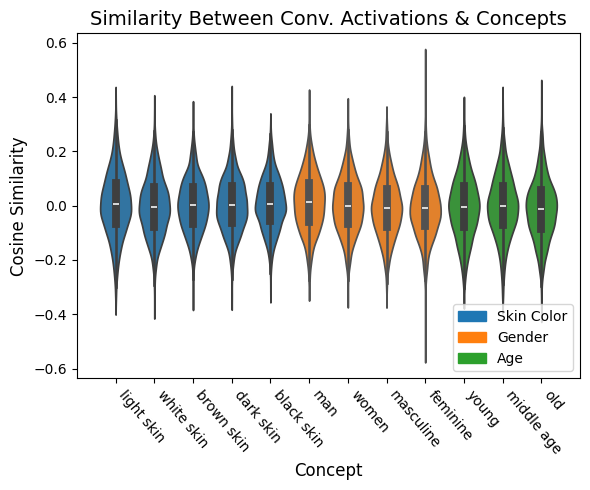

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

cos_sim_concat = np.vstack(cos_sim).T

for i_term, term_groups in enumerate([(0, 5), (5, 9), (9, 12)]): # terms
    for i in range(term_groups[0], term_groups[1]):
        sns.violinplot(x=[i] * len(cos_sim_concat[i]), y=cos_sim_concat[i], color="C"+str(i_term), ax=ax)
        
ax.set_xlim(-1, 12)
ax.set_xticks(np.arange(12), concept_terms, rotation=-50, ha='left')
ax.set_ylabel("Cosine Similarity", size=12)
ax.set_xlabel("Concept", size=12)
ax.set_title("Similarity Between Conv. Activations & Concepts", size=14)

ax.legend(handles=[
    mpatches.Patch(color='C0', label='Skin Color'),
    mpatches.Patch(color='C1', label='Gender'),
    mpatches.Patch(color='C2', label='Age'),
], loc='lower right')
plt.tight_layout();

### Similarity with Target Terms + Sensitive Terms

In [23]:
sensitive_terms = [
    'light skin', 'white skin', 'brown skin', 'dark skin', 'black skin', # skin
    'man', 'women', 'masculine', 'feminine', # gender
    'young', 'middle age', 'old', # age
]
class_terms = np.unique(df['class1'])

concept_terms = []

for i in sensitive_terms.copy():
    for j in class_terms:
        concept_terms.append(i + " " + j)

for j in class_terms:
    concept_terms.append(j)
    
concepts = clip.tokenize(concept_terms).to(device)

clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [18]:
# Convolutional dimensions
n_channels = [16, 16, 24, 24, 40, 40, 40, 80, 80, 80,
              80, 112, 112, 160, 160, 160, 960, 1]

# Initialize P and q_k
n_rows = 100
P = np.zeros((n_rows, len(concepts)))

q_k = [
    np.zeros((n_rows, i)) for i in n_channels
]    

for row in tqdm(range(n_rows), total=n_rows):

    # Load and preprocess image
    filepath = df['filepath'][row]
    img = Image.open(filepath)

    # Preprocess
    image = preprocess(img).unsqueeze(0).to(device)
    
    # 1. Compute P
    with torch.no_grad():
        logits_per_image, logits_per_text = clip_model(image, concepts)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    P[row] = probs

    # 2. Compute activations, q_k
    activation = {}
    _ = model(image)
    for i, k in enumerate(activation.keys()):
        # Activations per convolutional channel, e.g. "neuron"
        if k == "conv_head":
            # Last convolutional layer gets flatten
            q_k[i][row] = activation[k].cpu().numpy()[0].mean()
        else:
            q_k[i][row] = activation[k].cpu().numpy()[0].mean(axis=(1, 2))

# 3. Compute similarity between P and q_k
cos_sim = []
for i in range(len(q_k)):
    cos_sim.append(compute_cos_sim(P, q_k[i], demean=True).T)

  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
concepts_pred = []
for i in cos_sim:
    concepts_pred.append(
        [concept_terms[j] for j in np.argmax(i, axis=1)]
    )

In [69]:
# Concepts labels for first convolutional layer
concepts_pred[0]

['black skin astronaut',
 'white skin disk_jockey',
 'women carpenter',
 'women guitarist',
 'white skin disk_jockey',
 'skateboarder',
 'masculine nurse',
 'white skin repairman',
 'middle age tennis_player',
 'skateboarder',
 'young boatman',
 'white skin disk_jockey',
 'skateboarder',
 'feminine gardener',
 'masculine disk_jockey',
 'white skin disk_jockey']

In [70]:
# Concept labels for second convolutional layer
concepts_pred[1]

['feminine gardener',
 'feminine gardener',
 'white skin referee',
 'retailer',
 'light skin climber',
 'boatman',
 'brown skin nurse',
 'feminine gardener',
 'feminine gardener',
 'feminine judge',
 'dark skin craftsman',
 'young singer',
 'boatman',
 'light skin referee',
 'women judge',
 'machinist']

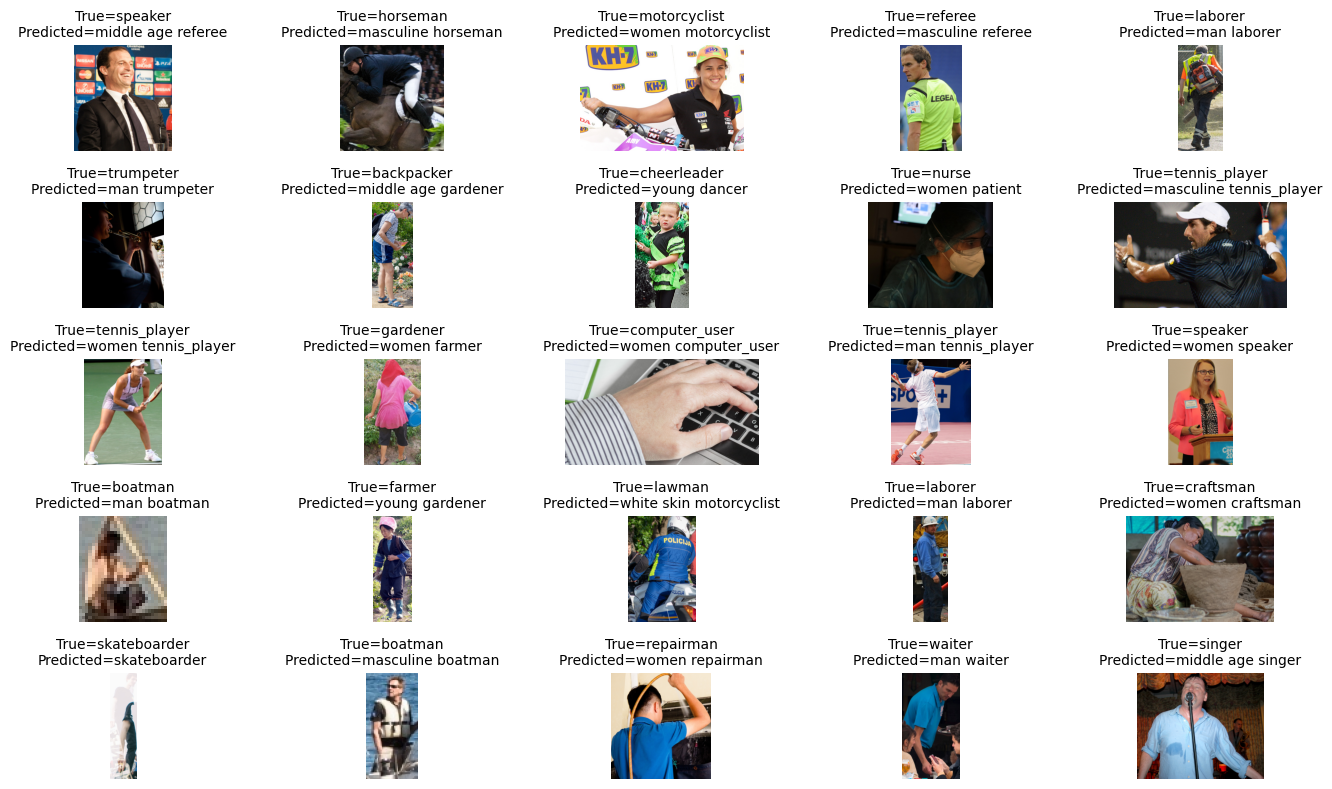

In [73]:
# Plot examples
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(14, 8))
axes = axes.flatten()

predicted_concepts = [concept_terms[i] for i in  np.argmax(P, axis=1)]

for row in range(25):
    filepath = df['filepath'][row]
    img = Image.open(filepath)
    
    # Apply bounding box around person
    j_start = int(round(df.iloc[row]['bounding_box']['x']))
    i_start = int(round(df.iloc[row]['bounding_box']['y']))
    i_end = i_start + int(round(df.iloc[row]['bounding_box']['height']))
    j_end = j_start + int(round(df.iloc[row]['bounding_box']['width']))
    img = np.array(img)[i_start:i_end+1, j_start:j_end+1]

    # Plot
    axes[row].imshow(img)
    axes[row].axis('off')
    axes[row].set_title(f"True={df.iloc[row]['class1']}\nPredicted={predicted_concepts[row]}", size=10)
    
plt.tight_layout();